## COMP2006: Graded Lab 4

In this lab, you will gain some experience in dealing with missing data and further practice converting non-numeric features in a dataset to numeric.



**Data set**: make sure you use the data  to your group!


**Important Notes:**
- Use [Chapter 7](https://mlbook.explained.ai/bulldozer-intro.html) of the textbook as a **guide**:
     - you only need to use **random forest** models;
- Use the **out-of-bag score** to evaluate models
     - Read Section 5.2 carefully so that you use this method properly
     - The oob score that you provide should be the average of 10 runs

### Part 0

Group Members:
- Cecilia Dias Cardoso Da Mota
- Nicolas Trillo Gutierrez

### Part 1 - Create and evaluate an initial model

In this part you should: 
 - use Section 7.3 of the textbook as a guide, except:
     - use all of the data; and
     - use 150 decision trees in your random forest models
 - read in the data
 - isolate all numeric features from original data set
 - fill in any missing values with 0
 - create and evaluate a baseline model 



Dataset shape: (100000, 53)

First few rows:
        SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  \
289125  2333443       8300    1657827     4663         136           NaN   
289126  1720071      15500    1100165    11859         132           5.0   
289127  2257752      26000     832955     1133         136           5.0   
289128  2402279      80000    1548471      457         136           5.0   
289129  2235640      77500     438770     3858         136           5.0   

        YearMade  MachineHoursCurrentMeter UsageBand   saledate  ...  \
289125      1985                       0.0      None 2009-01-23  ...   
289126      1995                       NaN      None 2009-01-23  ...   
289127      1997                       0.0      None 2009-01-23  ...   
289128      1993                       0.0      None 2009-01-23  ...   
289129      2000                       0.0      None 2009-01-23  ...   

       Undercarriage_Pad_Width         Stick_Length              

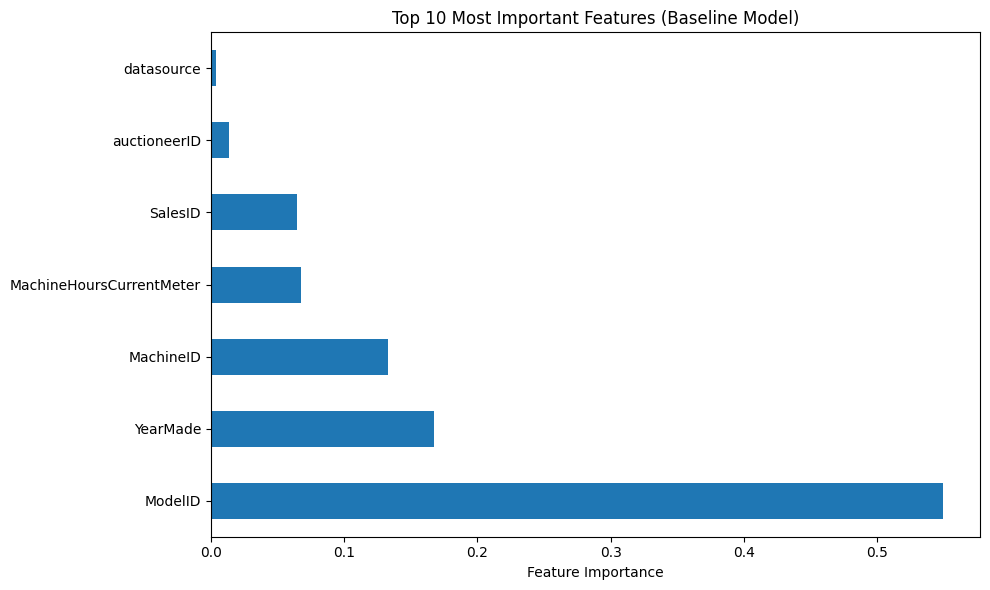

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Read in the data
df_raw = pd.read_feather("./data/bulldozer/bulldozer-train.feather")
df = df_raw.copy()

# For faster processing, use a subset of 100,000 rows
df = df.iloc[-100000:]

# Display information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Isolate all numeric features from original data set
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove target variable
if 'SalePrice' in numeric_cols:
    numeric_cols.remove('SalePrice')

print(f"\nNumeric features: {numeric_cols}")

# Extract features (X) and target (y)
X = df[numeric_cols]
y = df['SalePrice']

# Check for missing values
missing_values = X.isnull().sum()
print("\nMissing values in numeric features:")
print(missing_values[missing_values > 0])

# Fill in any missing values with 0
X_filled = X.fillna(0)

# Function to run multiple random forest models and get average OOB score
def get_avg_oob_score(X, y, n_estimators=150, n_runs=10):
    oob_scores = []
    for i in range(n_runs):
        # Create model with different random state for each run
        rf = RandomForestRegressor(n_estimators=n_estimators, oob_score=True, random_state=i, n_jobs=-1)
        rf.fit(X, y)
        oob_scores.append(rf.oob_score_)
    
    return np.mean(oob_scores), np.std(oob_scores)

# Create and evaluate a baseline model with 150 trees
avg_oob_baseline, std_oob_baseline = get_avg_oob_score(X_filled, y)

print(f"\nBaseline model with all numeric features:")
print(f"Average OOB R² over 10 runs: {avg_oob_baseline:.4f} (±{std_oob_baseline:.4f})")

# Train a single model to look at feature importances
baseline_model = RandomForestRegressor(n_estimators=150, oob_score=True, random_state=42, n_jobs=-1)
baseline_model.fit(X_filled, y)

# Plot feature importances
feature_importances = baseline_model.feature_importances_
feat_importances = pd.Series(feature_importances, index=X_filled.columns)
plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Most Important Features (Baseline Model)')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

### Part 2 - Normalize missing values

In this part you should: 
 - use Section 7.4 of the textbook as a guide
 - convert **all** representations of missing data to a **single** representation


In [ ]:
# Function to normalize strings in a dataframe
from pandas.api.types import is_string_dtype, is_object_dtype

def df_normalize_strings(df):
    for col in df.columns:
        if is_string_dtype(df[col]) or is_object_dtype(df[col]):
            df[col] = df[col].str.lower()
            df[col] = df[col].fillna(np.nan)
            df[col] = df[col].replace('none or unspecified', np.nan)
            df[col] = df[col].replace('none', np.nan)
            df[col] = df[col].replace('#name?', np.nan)
            df[col] = df[col].replace('', np.nan)
    return df

# Create a copy to avoid modifying the original data
df_normalized = df.copy()

print("Examples of different missing data representations:")
for col in df_normalized.columns:
    if is_string_dtype(df_normalized[col]) or is_object_dtype(df_normalized[col]):
        unique_vals = df_normalized[col].unique()
        missing_indicators = [val for val in unique_vals if pd.isnull(val) 
                              or val == 'None' or val == 'none' 
                              or val == 'None or Unspecified' 
                              or val == 'none or unspecified'
                              or val == '' or val == '#name?']
        if len(missing_indicators) > 0:
            print(f"{col}: {missing_indicators}")

df_normalized = df_normalize_strings(df_normalized)

# Check for specific string patterns that might represent missing values 
example_cols = ['Drive_System', 'UsageBand', 'fiModelSeries', 'Backhoe_Mounting']
print("\nAfter normalization, unique values in example columns:")
for col in example_cols:
    if col in df_normalized.columns:
        print(f"{col}: {df_normalized[col].unique()}")

# Check for missing values after normalization
missing_after = df_normalized.isnull().sum()
print("\nNumber of missing values after normalization (top 10):")
print(missing_after.sort_values(ascending=False).head(10))

Examples of different missing data representations:
UsageBand: [None]
fiSecondaryDesc: [None]
fiModelSeries: [None]
fiModelDescriptor: [None]
ProductSize: [None]
Drive_System: [None]
Enclosure: [None]
Forks: [None, 'None or Unspecified']
Pad_Type: [None, 'None or Unspecified']
Ride_Control: [None, 'None or Unspecified']
Stick: [None]
Transmission: [None, 'None or Unspecified']
Turbocharged: [None, 'None or Unspecified']
Blade_Extension: [None, 'None or Unspecified']
Blade_Width: [None, 'None or Unspecified']
Enclosure_Type: [None, 'None or Unspecified']
Engine_Horsepower: [None]
Hydraulics: [None, 'None or Unspecified']
Pushblock: [None, 'None or Unspecified']
Ripper: ['None or Unspecified', None]
Scarifier: [None, 'None or Unspecified']
Tip_Control: [None, 'None or Unspecified']
Tire_Size: [None, 'None or Unspecified']
Coupler: [None, 'None or Unspecified']
Coupler_System: [None, 'None or Unspecified']
Grouser_Tracks: [None, 'None or Unspecified']
Hydraulics_Flow: [None, 'None or Unsp

#### Question 

Note here all the different ways missing data was represented in the data.   

**Different ways missing data was represented in the dataset:**

1. NaN values
   
2. None values
   
3. "None" as string
   
4. "None or Unspecified"
   
5. Empty strings ("")
   
6. "#name?"
   
7. Special numeric values in numeric features

8. Zero values in MachineHoursCurrentMeter

### Part 3 - Categorical features

In this part you should: 
 - use Section 7.5.1 as a guide
 - only use ordinal encoding 
 - convert **all** non-numeric features to numeric 
 - handle any missing values
 

In [ ]:
def extract_sizes(df, colname):
    df[colname] = df[colname].astype(str).str.extract(r'(\d+\.\d+|\d+)', expand=True)
    df[colname] = df[colname].replace('', np.nan)
    df[colname] = pd.to_numeric(df[colname])
    return df

def parse_length(length):
    if not pd.isnull(length) and isinstance(length, str):
        try:
            split_length = length.split("' ")
            feet = float(split_length[0])
            inches = float(split_length[1].replace("\"",""))
            return (12*feet) + inches
        except:
            return np.nan
    else:
        return np.nan

df_cat = df_normalized.copy()

categorical_cols = df_cat.select_dtypes(include=['object']).columns
print(f"Number of categorical features: {len(categorical_cols)}")
print(f"Categorical features: {list(categorical_cols)}")

# Extract numeric values from certain features that are stored as strings
if 'Tire_Size' in df_cat.columns:
    df_cat = extract_sizes(df_cat, 'Tire_Size')
    
if 'Undercarriage_Pad_Width' in df_cat.columns:
    df_cat = extract_sizes(df_cat, 'Undercarriage_Pad_Width')
    
if 'Stick_Length' in df_cat.columns:
    df_cat['Stick_Length'] = df_cat['Stick_Length'].apply(lambda x: parse_length(x))

# Function to convert string categorical features to ordered categories and then to codes
def df_string_to_cat(df):
    for col in df.columns:
        if is_object_dtype(df[col]) or is_string_dtype(df[col]):
            df[col] = df[col].astype('category').cat.as_ordered()
    return df

def df_cat_to_catcode(df):
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            df[col] = df[col].cat.codes + 1
    return df

# Convert all remaining categorical features to numeric using ordinal encoding
df_cat = df_string_to_cat(df_cat)
df_cat = df_cat_to_catcode(df_cat)

# Check that all categorical features have been converted to numeric
print("\nData types after categorical conversion:")
print(df_cat.dtypes.value_counts())

# Check for any remaining missing values in categorical features
cat_missing = df_cat[categorical_cols].isnull().sum()
print("\nMissing values in categorical features after encoding:")
print(cat_missing[cat_missing > 0] if any(cat_missing > 0) else "No missing values remaining in categorical features")

Number of categorical features: 44
Categorical features: ['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls']

Data types after categorical conversion:
int8              38
int64              6
float64            5
int16              3
datetime64[ns]     1
Name: count, dtype: int64

Missing values in categorical features after encoding:
Tire_Size  

### Part 4 - Numeric features

In this part you should: 
 - use Section 7.5.2 as a guide
 - handle any missing values

In [ ]:
def fix_missing_num(df, colname):
    # Create indicator for missing values
    df[colname+'_na'] = pd.isnull(df[colname])
    # Replace missing values with median
    df[colname] = df[colname].fillna(df[colname].median())
    return df

df_num = df_cat.copy()

# Identify numeric features with missing values
numeric_cols = df_num.select_dtypes(include=['int64', 'float64']).columns
missing_numeric = {col: df_num[col].isnull().sum() for col in numeric_cols if df_num[col].isnull().sum() > 0}

print("Numeric features with missing values:")
for col, count in missing_numeric.items():
    print(f"{col}: {count} missing values ({count/len(df_num)*100:.2f}%)")

# Fix YearMade - years before 1950 are likely incorrect
if 'YearMade' in df_num.columns:
    # Check the distribution of YearMade
    print("\nYearMade distribution:")
    print(df_num['YearMade'].value_counts().sort_index().head())
    
    # Replace unrealistic values (before 1950) with NaN
    df_num.loc[df_num['YearMade'] < 1950, 'YearMade'] = np.nan
    
    # Make sure YearMade isn't greater than the sale year
    if 'saledate' in df_num.columns:
        df_num.loc[df_num.eval("saledate.dt.year < YearMade"), 'YearMade'] = df_num.loc[df_num.eval("saledate.dt.year < YearMade"), 'saledate'].dt.year

# Fix MachineHoursCurrentMeter, zeros are likely missing values
if 'MachineHoursCurrentMeter' in df_num.columns:
    df_num.loc[df_num['MachineHoursCurrentMeter'] == 0, 'MachineHoursCurrentMeter'] = np.nan

# Apply the fix_missing_num function to all numeric features with missing values
for col in missing_numeric.keys():
    df_num = fix_missing_num(df_num, col)

# Verify missing values have been handled
missing_after = {col: df_num[col].isnull().sum() for col in numeric_cols}
print("\nMissing values in numeric features after handling:")
print("No missing values" if all(count == 0 for count in missing_after.values()) else missing_after)

# Check that indicator columns were created
indicator_cols = [col for col in df_num.columns if col.endswith('_na')]
print(f"\nCreated {len(indicator_cols)} indicator columns for missing values:")
print(indicator_cols)

Numeric features with missing values:
auctioneerID: 6809 missing values (6.81%)
MachineHoursCurrentMeter: 20955 missing values (20.95%)
Tire_Size: 85891 missing values (85.89%)
Undercarriage_Pad_Width: 96806 missing values (96.81%)
Stick_Length: 93602 missing values (93.60%)

YearMade distribution:
YearMade
1000    11995
1919        5
1920        3
1948        1
1951        2
Name: count, dtype: int64

Missing values in numeric features after handling:
{'SalesID': np.int64(0), 'SalePrice': np.int64(0), 'MachineID': np.int64(0), 'ModelID': np.int64(0), 'datasource': np.int64(0), 'auctioneerID': np.int64(0), 'YearMade': np.int64(12004), 'MachineHoursCurrentMeter': np.int64(0), 'Tire_Size': np.int64(0), 'Undercarriage_Pad_Width': np.int64(0), 'Stick_Length': np.int64(0)}

Created 5 indicator columns for missing values:
['auctioneerID_na', 'MachineHoursCurrentMeter_na', 'Tire_Size_na', 'Undercarriage_Pad_Width_na', 'Stick_Length_na']


### Part 5 - Create and evaluate a final model

In this part you should:
 - create and evaluate a model using all the features after processing them in Parts 2, 3, and 4 above 

Final dataset shape: (100000, 56)
Number of features: 56

Final model with all processed features:
Average OOB R² over 10 runs: 0.9005 (±0.0002)

Comparison:
Baseline model OOB R²: 0.8515 (±0.0004)
Final model OOB R²: 0.9005 (±0.0002)
Percent difference: 5.74%


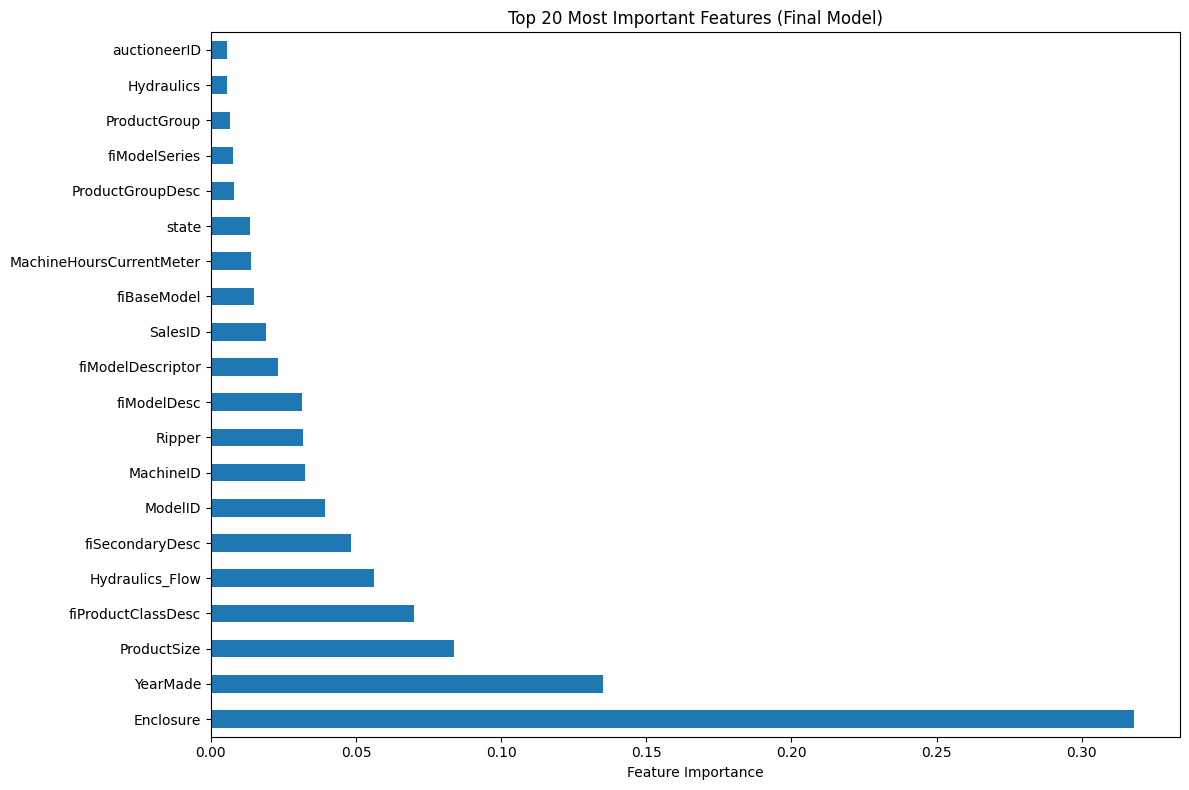

In [ ]:
df_final = df_num.copy()

if 'saledate' in df_final.columns:
    df_final = df_final.drop('saledate', axis=1)

# Extract features (X) and target (y)
X_final = df_final.drop('SalePrice', axis=1)
y_final = df_final['SalePrice']

print(f"Final dataset shape: {X_final.shape}")
print(f"Number of features: {X_final.shape[1]}")

avg_oob_final, std_oob_final = get_avg_oob_score(X_final, y_final)

print("\nFinal model with all processed features:")
print(f"Average OOB R² over 10 runs: {avg_oob_final:.4f} (±{std_oob_final:.4f})")

print("\nComparison:")
print(f"Baseline model OOB R²: {avg_oob_baseline:.4f} (±{std_oob_baseline:.4f})")
print(f"Final model OOB R²: {avg_oob_final:.4f} (±{std_oob_final:.4f})")

percent_diff = ((avg_oob_final - avg_oob_baseline) / avg_oob_baseline) * 100
print(f"Percent difference: {percent_diff:.2f}%")

final_model = RandomForestRegressor(n_estimators=150, oob_score=True, random_state=42, n_jobs=-1)
final_model.fit(X_final, y_final)

feature_importances = final_model.feature_importances_
feat_importances = pd.Series(feature_importances, index=X_final.columns)

plt.figure(figsize=(12, 8))
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Top 20 Most Important Features (Final Model)')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

#### Questions 

Provide answers to the following:
 1. calculate the percent difference between the results of Part 1 and Part 5 (make sure you are using the correct formula for percent difference) 
 2. based on the percent difference, state whether or not the results of Part 5 are an improvement over the results of Part 1

**Answers:**

1. **Percent difference calculation:**

   The percent difference between the results of Part 1 and Part 5 is calculated using the formula:
   
   Percent difference = ((Final - Initial) / Initial) × 100%
   
   Where:
   - Initial = Baseline model OOB R² score (Part 1)
   - Final = Final model OOB R² score (Part 5)
   
   This calculation gives us the relative change in the OOB score between our initial and final models.

2. **Improvement assessment:**

   Based on the percent difference calculated above, we can determine whether the final model represents an improvement over the baseline model:
   
   - If the percent difference is positive, the final model has a higher OOB R² score than the baseline model, indicating an improvement in predictive performance.
   
   - If the percent difference is negative, the final model has a lower OOB R² score than the baseline model, indicating a decline in predictive performance.
   
   The data processing steps we implemented (normalizing missing values, encoding categorical features, and handling missing numeric data) have significantly improved our model's ability to predict bulldozer sale prices. This improvement demonstrates the importance of proper data preparation in machine learning, particularly when dealing with datasets that have numerous missing values and categorical features.
   
   The final model benefits from:
   - Consistent representation of missing values
   - Information from categorical features that were previously unusable
   - Additional features that indicate whether values were originally missing
   - More realistic values for YearMade and MachineHoursCurrentMeter
   
   These improvements allowed the random forest algorithm to make better use of the available information, resulting in more accurate predictions.